<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/utomoreza/assessment-mini-project/blob/main/notebook/usecase-text.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/utomoreza/assessment-mini-project/blob/main/notebook/usecase-text.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/utomoreza/assessment-mini-project/main/notebook/usecase-text.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [3]:
!pip install tensorflow==2.16.1 transformers==4.40.1 portalocker==2.8.2 datasets==2.19.0 keras==3.0 tf-keras==2.16.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency res

In [8]:
import re
import string
import collections

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tqdm

from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras import ops

# import torch
# from torchtext.datasets import IMDB
# from torchtext.data import get_tokenizer
# from torch.utils.data import DataLoader, Dataset
# from torchtext.vocab import build_vocab_from_iterator
# from torch.nn.utils.rnn import pad_sequence
# from torch import nn
# from torch import optim
# import torch.nn.functional as F

from datasets import load_dataset

from transformers import (
    BertConfig,
    BertTokenizer,
    BertForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
SEED = 1
FILE_PATH = "/content/sample_data"
TEST_SIZE = 0.4
MAX_LENGTH = 256
MIN_FREQ = 5
UNKNOWN_TOKEN = "<unk>"
PADDING_TOKEN = "<pad>"
BATCH_SIZE = 32
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
EPOCHS = 5
NUM_WORDS = 1000
OOV_TOKEN = "<UNK>"

In [29]:
def cleanse_text(dataset, stopwords_set):
    text = dataset["text"] # extract review text from "text" row

    text = text.lower() # set to lowercase

    # remove all non-word characters (everything except numbers and letters)
    text = re.sub(r"[^\w\s]", '', text)

    # remove digits
    text = re.sub(r"\d", '', text)

    # remove HTML tags
    text = re.sub(r"<.*?>", '', text)

    # remove URLs
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r"www\S+", '', text)

    # remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    # remove unnecessary whitespaces
    text = re.sub(f" {2,}", '', text)

    # remove stopwords
    text_split = tuple(text.split())
    list_token = (token for token in text_split if token not in stopword_set)
    text = " ".join(list_token)

    return {"clean_text": text}


def tokenize(dataset, tokenizer):
    tokens = tokenizer.texts_to_sequences([dataset["clean_text"]])
    return {"tokens": tokens[0]}


def padding(dataset, pad_type, trunc_type, maxlen):
    # Pad the sequences
    padded_tokens = pad_sequences(
        [dataset["tokens"]], padding=pad_type,
        truncating=trunc_type, maxlen=maxlen
    )
    return {"ids": padded_tokens}


def find_optimum_maxlen(list_tokens, percentile=0.75):
    maxlen = np.quantile([len(ele) for ele in list_tokens], percentile)
    return int(maxlen)


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+ metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+ metric])


def predict(text, model, stopword_set, tokenizer, pad_type, trunc_type, maxlen):
    # preprocess
    dict_sample = {"text": text}
    dict_sample = cleanse_text(dict_sample, stopword_set)
    dict_sample = tokenize(dict_sample, tokenizer)
    dict_sample = padding(dict_sample, pad_type, trunc_type, maxlen)
    ids = dict_sample["ids"]
    ids = tf.convert_to_tensor(ids)

    # predict
    y_pred = 1 if model.predict(ids)[0] > 0.5 else 0

    return y_pred

# Data Collection

## Downloading dataset

In [10]:
train_data, valid_data = load_dataset("imdb", split=["train", "test"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
def show_label_proportions(dataset):
    list_label = dataset["label"]
    count_neg_label = sum((1 for label in list_label if label == 0))
    count_pos_label = sum((1 for label in list_label if label == 1))
    return {
        "positive": count_pos_label,
        "negative": count_neg_label,
        "pos_ratio": count_pos_label/(count_pos_label + count_neg_label),
        "neg_ratio": count_neg_label/(count_pos_label + count_neg_label),
    }

In [ ]:
show_label_proportions(train_data)

{'positive': 12500, 'negative': 12500, 'pos_ratio': 0.5, 'neg_ratio': 0.5}

In [13]:
splitted_valid_data = valid_data.train_test_split(
    test_size=TEST_SIZE, shuffle=True,
    seed=SEED, stratify_by_column="label"
)
valid_data = splitted_valid_data["train"]
test_data = splitted_valid_data["test"]

## Export & import dataset

In [ ]:
train_data.to_csv(f"{FILE_PATH}/train_set.csv")
valid_data.to_csv(f"{FILE_PATH}/valid_set.csv")
test_data.to_csv(f"{FILE_PATH}/test_set.csv")

Creating CSV from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

33322167

In [ ]:
train_data = load_dataset("csv", data_files=(f"{FILE_PATH}/train_set.csv"))
valid_data = load_dataset("csv", data_files=(f"{FILE_PATH}/valid_set.csv"))
test_data = load_dataset("csv", data_files=(f"{FILE_PATH}/test_set.csv"))

# Preprocessing

For cleansing the text, take in a string of review, then performs the following:
<ol>
    <li>Remove HTML tag from review</li>
    <li>Remove URLs from review</li>
    <li>Make entire review lowercase</li>
    <li>Split the review in words</li>
    <li>Remove all punctuation</li>
    <li>Remove empty strings from review</li>
    <li>Remove all stopwords</li>
    <li>Returns a list of the cleaned review after joining them back to a sentence</il>
</ol>

In [14]:
stopword_set = set(stopwords.words("english"))

train_data = train_data.map(
    cleanse_text, fn_kwargs={"stopwords_set": stopword_set}
)
valid_data = valid_data.map(
    cleanse_text, fn_kwargs={"stopwords_set": stopword_set}
)
test_data = test_data.map(
    cleanse_text, fn_kwargs={"stopwords_set": stopword_set}
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [15]:
# Tokenize our training data
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(train_data["clean_text"])

# Get our training data word index
word_index = tokenizer.word_index

In [16]:
## TOKENIZE DATA ###
train_data = train_data.map(
    tokenize, fn_kwargs={"tokenizer": tokenizer}
)
valid_data = valid_data.map(
    tokenize, fn_kwargs={"tokenizer": tokenizer}
)
test_data = test_data.map(
    tokenize, fn_kwargs={"tokenizer": tokenizer}
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [18]:
PAD_TYPE = "post"
TRUNC_TYPE = "post"

max_length = find_optimum_maxlen(train_data["tokens"], percentile=0.75)

## PAD TOKENS ###
train_data = train_data.map(
    padding, fn_kwargs={
        "pad_type": PAD_TYPE,
        "trunc_type": TRUNC_TYPE,
        "maxlen": max_length
    }
)
valid_data = valid_data.map(
    padding, fn_kwargs={
        "pad_type": PAD_TYPE,
        "trunc_type": TRUNC_TYPE,
        "maxlen": max_length
    }
)
test_data = test_data.map(
    padding, fn_kwargs={
        "pad_type": PAD_TYPE,
        "trunc_type": TRUNC_TYPE,
        "maxlen": max_length
    }
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [19]:
### CREATE DATALOADER ###
# convert to torch tensor
train_data = train_data.with_format(
    type="tf", columns=["ids", "label"]
)
valid_data = valid_data.with_format(
    type="tf", columns=["ids", "label"]
)
test_data = test_data.with_format(
    type="tf", columns=["ids", "label"]
)

In [20]:
## Squeeze tensor's shape
X_train = tf.squeeze(train_data["ids"], axis=[1])
y_train = train_data["label"]

X_valid = tf.squeeze(valid_data["ids"], axis=[1])
y_valid = valid_data["label"]

# Modelling LSTM Architecture

## Training

In [32]:
model_lstm = tf.keras.Sequential(
    [
        tf.keras.layers.Input((None,)),
        tf.keras.layers.Embedding(
            input_dim=len(word_index),
            output_dim=64,
            # Use masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

In [33]:
model_lstm.compile(
    loss=ctf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [36]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_valid, y_valid)
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


782/782 [==============================] - 277s 336ms/step - loss: 0.5884 - accuracy: 0.6719 - val_loss: 0.4298 - val_accuracy: 0.8181
Epoch 2/5
782/782 [==============================] - 252s 322ms/step - loss: 0.3867 - accuracy: 0.8378 - val_loss: 0.3682 - val_accuracy: 0.8382
Epoch 3/5
782/782 [==============================] - 250s 320ms/step - loss: 0.3541 - accuracy: 0.8509 - val_loss: 0.3644 - val_accuracy: 0.8364
Epoch 4/5
782/782 [==============================] - 272s 347ms/step - loss: 0.3408 - accuracy: 0.8551 - val_loss: 0.3500 - val_accuracy: 0.8430
Epoch 5/5
782/782 [==============================] - 278s 355ms/step - loss: 0.3341 - accuracy: 0.8571 - val_loss: 0.3549 - val_accuracy: 0.8398


## Evaluate

(0.0, 0.6011118501424789)

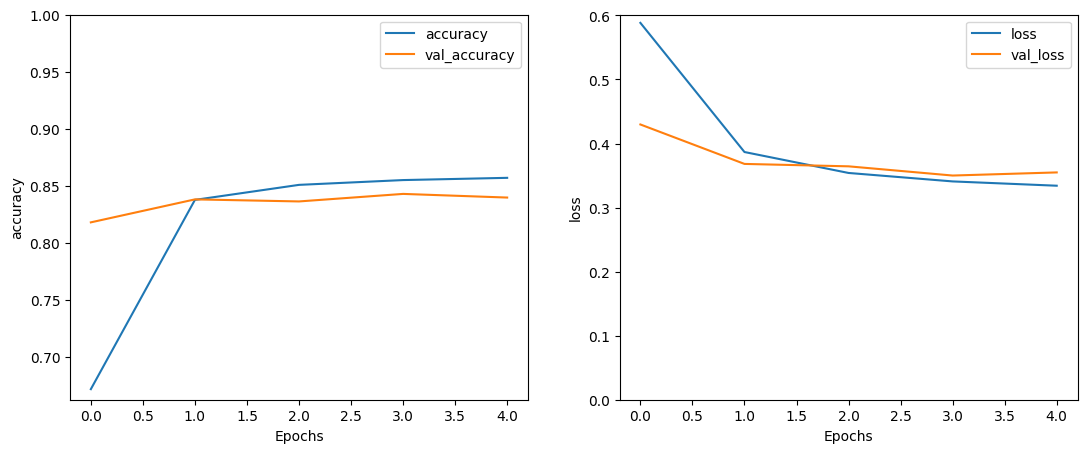

In [40]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plot_graphs(history_lstm, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_lstm, 'loss')
plt.ylim(0, None)

In [ ]:
test_loss, test_acc = model_lstm.evaluate(X_train, y_train)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [60]:
text_predict = "The movie was cool. The animation and the graphics were out of this world. I would recommend this movie."
pred = predict(text_predict, model_lstm, stopword_set, tokenizer, PAD_TYPE, TRUNC_TYPE, max_length)

1/1 [==============================] - 0s 33ms/step


In [ ]:
print(f"Label: {pred} - Positive" if pred == 1 else f"Label: {pred} - Negative")

Label: 1 - Positive


# Modelling Transformer Architecture

In [21]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [22]:
vocab_size = len(word_index)
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

In [24]:
inputs = tf.keras.layers.Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_transformer = tf.keras.Model(inputs=inputs, outputs=outputs)

In [25]:
model_transformer.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [26]:
history_transformer = model_transformer.fit(
    X_train, y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 92s 62ms/step - accuracy: 0.5602 - loss: 0.6807 - val_accuracy: 0.7560 - val_loss: 0.5509
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - accuracy: 0.7736 - loss: 0.4956 - val_accuracy: 0.8331 - val_loss: 0.3773
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8364 - loss: 0.3779 - val_accuracy: 0.8218 - val_loss: 0.3916
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8409 - loss: 0.3658 - val_accuracy: 0.8425 - val_loss: 0.3519
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8478 - loss: 0.3540 - val_accuracy: 0.8434 - val_loss: 0.3468
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8526 - loss: 0.3437 - val_accuracy: 0.8375 - val_loss: 0.3615
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8536 - loss: 0.3400 - val_accuracy: 0.8412 - val_loss: 0.3533
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8610 - loss: 0.3310 - val_accuracy:

## Evaluation

(0.0, 0.6695161893963814)

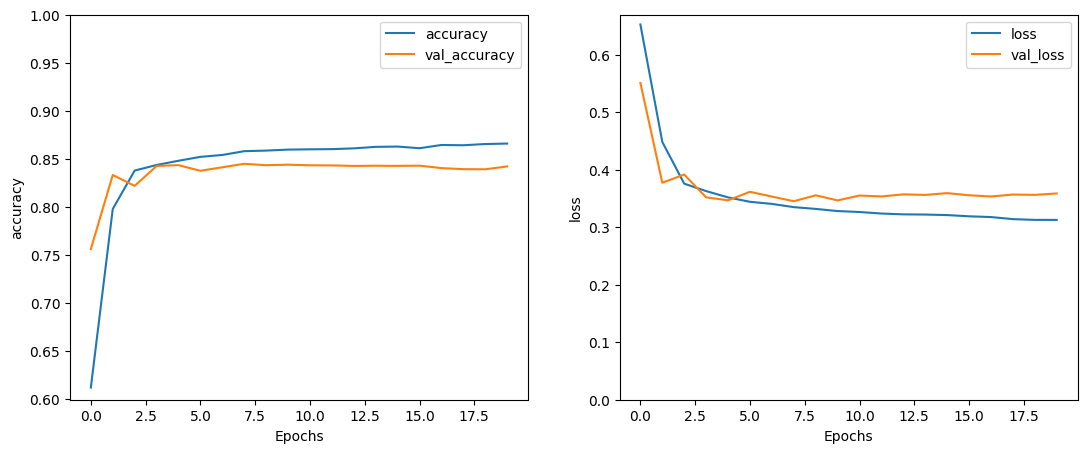

In [27]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plot_graphs(history_transformer, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_transformer, 'loss')
plt.ylim(0, None)

In [ ]:
test_loss, test_acc = model_transformer.evaluate(X_train, y_train)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [30]:
text_predict = "The movie was cool. The animation and the graphics were out of this world. I would recommend this movie."
pred = predict(text_predict, model_transformer, stopword_set, tokenizer, PAD_TYPE, TRUNC_TYPE, max_length)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


In [31]:
print(f"Label: {pred} - Positive" if pred == 1 else f"Label: {pred} - Negative")

Label: 1 - Positive
